In [3]:
import pandas as pd
import requests 
import json 
import csv 
import time
import datetime
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/babu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
def print_scores(model):
    print(f'train score: {model.score(X_train, y_train)}')
    print(f'test score: {model.score(X_test, y_test)}')

In [6]:
df_reviews = pd.read_csv('../data/Las_Vegas_400_reviews.csv')
df_revs_combined = df_reviews.groupby(['business_id', 'name', 
                               'address', 'city' ,
                               'state', 'postal_code', 
                               'latitude' ,'longitude' , 
                               'stars', 'review_count', 
                               'is_open', 'attributes', 'categories']).agg({'text': ' '.join})
df_revs_combined = df_revs_combined.reset_index()
df_revs_combined['review_wc'] = df_revs_combined['text'].str.split().str.len()

X = df_revs_combined['text']
y = df_revs_combined['is_open']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=251)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((297,), (100,), (297,), (100,))

In [7]:
pipe = make_pipeline(CountVectorizer(max_features=500), 
                     StandardScaler(with_mean=False),
                     RandomForestClassifier()
                    )

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=500)),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier', RandomForestClassifier())])

In [9]:
print_scores(pipe)

train score: 1.0
test score: 0.65


# MultinomialNB

In [10]:
lemmatizer = WordNetLemmatizer()
def split_lemmatize(text):
    text_lower = text.lower()
    lemmatizer = WordNetLemmatizer()
    return " ".join([ lemmatizer.lemmatize(x)  for x in text_lower.split()])

In [11]:
pipe = make_pipeline(CountVectorizer(preprocessor=split_lemmatize,  max_features=100), 
                    MultinomialNB())

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=100,
                                 preprocessor=<function split_lemmatize at 0x7fdd5a739280>)),
                ('multinomialnb', MultinomialNB())])

In [13]:
print_scores(pipe)

train score: 0.6936026936026936
test score: 0.61


In [15]:
y_mnb_preds = pipe.predict(X_test)

In [16]:
conf_mat = confusion_matrix(y_test, y_lr_preds)
print(conf_mat)

[[31 20]
 [19 30]]


In [17]:
tn, fp, fn,tp = confusion_matrix(y_test, y_lr_preds).ravel()
print(tn, fp, fn,tp)

31 20 19 30


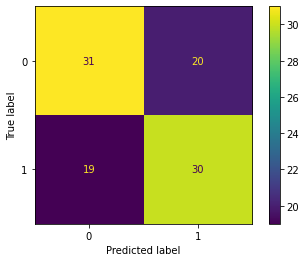

In [18]:
plot_confusion_matrix(pipe, X_test,  y_test)

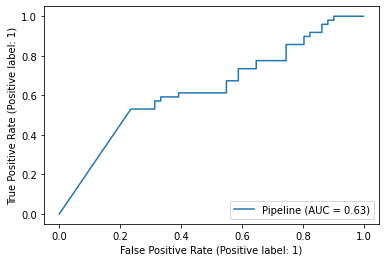

In [19]:
plot_roc_curve(pipe, X_test, y_test);

In [20]:
precision = tp / (tp+fp)
recall = tp / (tp+fn)
specificity = tn/(tn+fp)
balanced_accuracy = (specificity + recall)/2
ac = accuracy_score(y_test, y_lr_preds)
fpr = fp / (fp+tn) # False Positive Rate 
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" Specificity: {recall}")
print(f" Balanced Accuracy: {balanced_accuracy}")
print(f" Accuracy Score: {ac}")
print(f" False Positive Rate : {fpr}")

 Precision: 0.6
 Recall: 0.6122448979591837
 Specificity: 0.6122448979591837
 Balanced Accuracy: 0.6100440176070427
 Accuracy Score: 0.61
 False Positive Rate : 0.39215686274509803


# Keras

In [101]:
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Dropout

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [58]:
# def create_model(units=10):
#     model = Sequential()
#     model.add(Dense(12, activation='relu'))
#     model.add(Dense(units = units, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [92]:
# def create_model(units=60):
#     model = Sequential()
#     model.add(Dense(12, input_shape=(750,), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dense(units = units, activation='relu'))
#     model.add(Dense(units = units, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [119]:
def create_model(units=60):
    model = Sequential()
    model.add(Dense(12, input_shape=(750,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [112]:
#model = KerasClassifier(build_fn=create_model, epochs = 10, verbose = 0)
model = KerasClassifier(build_fn=create_model, epochs = 10)

In [60]:
sscaler = StandardScaler(with_mean=False)
tf_vect = TfidfVectorizer(stop_words='english', max_features=750)




In [63]:
X_train_trans = tf_vect.fit_transform(X_train)

In [64]:
X_test_trans = tf_vect.transform(X_test)

In [65]:
X_train_trans = X_train_trans.toarray()
X_test_trans = X_test_trans.toarray()

In [113]:
pipe = make_pipeline(sscaler,model)

In [77]:
X_train_trans.shape, X_test_trans.shape

((297, 750), (100, 750))

In [94]:
pipe.fit(X_train_trans, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdcf82d8d90>)])

In [95]:
params = {'kerasclassifier__units': [10, 20, 100]}

In [114]:
grid = GridSearchCV(pipe, param_grid=params)

In [115]:
grid.fit(X_train_trans, y_train)

Epoch 1/10
8/8 [==============================] - 0s 1ms/step - loss: 0.6905 - accuracy: 0.5278
Epoch 2/10
8/8 [==============================] - 0s 1ms/step - loss: 0.6668 - accuracy: 0.6252
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6199 - accuracy: 0.7394
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.7818
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.8068
Epoch 6/10
8/8 [==============================] - 0s 1ms/step - loss: 0.3267 - accuracy: 0.8960
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2056 - accuracy: 0.9429
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9252
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1062 - accuracy: 0.9782
Epoch 10/10
2/2 [==============================] - 0s 1ms/step - loss: 0.8606 - accuracy: 0.7500
Epoch 1/10
8/8 [=======================

GridSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kerasclassifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdcc46beaf0>)]),
             param_grid={'kerasclassifier__units': [10, 20, 100]})

In [116]:
grid.score(X_train_trans, y_train)

10/10 [==============================] - 0s 618us/step - loss: 0.0498 - accuracy: 0.9865


0.9865319728851318

In [117]:
grid.score(X_test_trans, y_test)

4/4 [==============================] - 0s 864us/step - loss: 1.0025 - accuracy: 0.6900


0.6899999976158142

In [118]:
grid.best_params_

{'kerasclassifier__units': 10}